In [25]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import sklearn.linear_model as lm
import sklearn.preprocessing as pre
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import seaborn as sns

import harness

In [2]:
flights_train = harness.read_flights('../data/flights_train.csv')
flights_test = harness.read_flights('../data/flights_test.csv')

In [3]:
flights_clean = harness.clean_train(flights_train)

In [4]:
x_transform = harness.chain(
    harness.keep_only_test_columns,
    [harness.make_weather_dummies, flights_clean],
    [harness.transfer_grouped_means, flights_clean, 100, 'origin', 'dest'],
    harness.only_numeric,
    harness.scale,
    harness.powers_of_time,
    [
        harness.drop,
        'crs_dep_time', 'crs_arr_time', 'has_origin__dest_mean',
        'crs_dep_time_hours', 'crs_arr_time_hours'
    ]
)
transformer = harness.DataTransformer(x_transform)

In [11]:
x_train, y_train = transformer.extract_transform(flights_clean)

In [13]:
def train_model():
    linreg = lm.Ridge(random_state=42)
    grid_search = ms.GridSearchCV(
        linreg, dict(alpha=[10 ** i for i in range(-6, 7)]),
    )
    grid_search.fit(x_train.values, y_train.values)
    harness.save(grid_search.best_estimator_, 'last_hurrah_model')

In [14]:
train_model()

In [15]:
linreg = harness.load('last_hurrah_model')
linreg_model = harness.TrainedModel(linreg, transformer)

In [16]:
{col: coef for col, coef in zip(x_train.columns, linreg.coef_[0])}

{'crs_elapsed_time': -1.5962103423135698,
 'distance': 0.745691684519976,
 'cold_o': -0.36177932766262794,
 'fog_o': -4.461323087210714,
 'hail_o': 0.01484797953977093,
 'precipitation_o': 1.8012519060702725,
 'rain_o': -1.6817137829576216,
 'snow_o': 1.0915573051854508,
 'storm_o': -0.14914778411726573,
 'severity_o': 7.611527896088642,
 'cold_d': -0.5438339013617091,
 'fog_d': -1.9288765114082442,
 'hail_d': 0.09167141129978061,
 'precipitation_d': 0.654595077313891,
 'rain_d': 0.2776559320422423,
 'snow_d': 0.7658317631870106,
 'storm_d': 0.4077666649614115,
 'severity_d': 3.890845685621152,
 'origin__dest_mean': 1.9826872304495207,
 'crs_dep_time_hours_1': 10.452321351240391,
 'crs_dep_time_hours_2': -3405.0488024175693,
 'crs_dep_time_hours_3': -28.74941127531295,
 'crs_dep_time_hours_4': 3550.7718284167827,
 'crs_dep_time_hours_5': 17.078460616490418,
 'crs_dep_time_hours_6': -1219.63087740833,
 'crs_arr_time_hours_1': 181.1498717675267,
 'crs_arr_time_hours_2': 124.4190863400513

In [17]:
linreg_model.validate(harness.clean_train(flights_test))[3]

R squared: 0.0257
R squared (early = 0): -0.00745
R squared (only delay): -0.181

In [19]:
linreg_model.submit(
    '../data/test.csv', 'last_hurrah_submission.csv', 'predicted_delay'
)

In [31]:
coeffs = pd.DataFrame({
    'Feature': x_train.columns[:19],
    'Importance': np.abs(linreg.coef_[0][:19])
})

In [40]:
important_features = coeffs.sort_values(by='Importance', ascending=False).head(5)

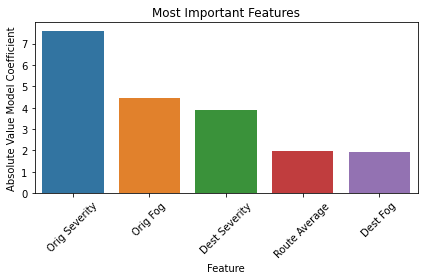

In [43]:
ax = sns.barplot(data=important_features, x='Feature', y='Importance')
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.title('Most Important Features')
plt.xticks(
    [0, 1, 2, 3, 4],
    labels=['Orig Severity', 'Orig Fog', 'Dest Severity', 'Route Average', 'Dest Fog']
)
plt.ylabel('Absolute Value Model Coefficient')
plt.tight_layout()
plt.savefig('importance.png', dpi=200)
plt.show()